空気抵抗による落下シミュレーション  
http://docsdrive.com/pdfs/academicjournals/srj/2016/1-9.pdf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math

In [2]:
MU = 3.986*10**5#地球重力定数[km^3/s^2]
R_po = 6600.#パーキング軌道半径[km]
Delta_i = 30.#種子島の緯度[deg]
PI = np.pi
J2 = 1082.628*10**(-6)#J2帯状調和関数係数
R_e = 6

In [3]:
G = 9.81 #重力加速度[m/s^2]
R_earth = 6378 #地球の半径[km]
SCALE_HEIGHT = 8.432#スケールハイト[km]
RHO_0 = 1.225#標準大気密度[kg/m^3]
H_reEntry = 200 #大気圏高度[km]
M_earth = 5.9724*10**24
## すまん、ここ詰める必要あるな
v_reEntry = 7.0 #再突入の速度(一例)[km/s]
gamma_reEntry = -0.001#再突入時の経路角(結構浅め)[deg]

#機体によるので、あとで
M_capcell = 16.3 #はやぶさ参照[kg]
A = 0.2 #ハヤブサよりちょい大きめ[kg]
Rn = 0.2#てきとー
#なんかを参照
Cd = 2.2
Cl = 0.7
DT = 0.01#刻み


In [24]:
3E-01

0.3

In [28]:
aa = [[-3.322622E-6,9.111460E-4,-0.2609971,5.944694],
    [0.000000,2.873405E-5,-0.008492037,0.6541179,-23.62010],
    [-1.240774E-5,0.005162063,-0.8048342,55.55996,-1443.338],
    [0.00000,-8.854164E-05,0.03373254,-4.390837,176.5294],
    [3.661771E-7,-2.154344E-4,0.04809214,-4.884744,172.3597],
    [1.906032E-8,-1.527799E-5,0.004724294,-0.6992340,20.50921],
    [1.199282E-9,-1.451051E-6,6.910474E-4,-0.1736220,-5.321644],
    [1.140564E-10,-2.130756E-7,1.570762E-4,-0.07029296,-12.89844],
    [8.105631E-12,-2.358417E-9,-2.635110E-6,-0.01562608,-20.02246],
    [-3.701195E-12,-8.608611E-9,5.118829E-5,-0.06600998,-6.137674]]

SyntaxError: invalid character in identifier (<ipython-input-28-841c76b15bdf>, line 1)

In [5]:
def get_density(z):
    matrix = np.array([[0.,-3,322622e-4,9.111460e-4,-02609971,5.944694],
                       [0.,],
                       [],
                       [],
                       []
                      ])
    if z<91:
        
    return RHO_0*np.exp(-h/SCALE_HEIGHT)

In [20]:
get_density(100)

8.661334926631736e-06

空気抵抗による高度落下を計算。  
\begin{align*}
\frac{dr}{dt} = -\frac{\rho V C_d A_s r}{m} = -\rho \frac{C_d A_s}{m}\sqrt{GMr}
\end{align*}

In [6]:
def get_drdt(r,Cd,As,m):
    """ r,drの単位は[km] """
    rho = get_density(r-R_earth)
    return (-rho*Cd*As*np.sqrt(G*M_earth*r*1000)/m) /1000

def solve_air_drag_eq(r0,dt=10**1,nstep=10**5,Cd_sat=2.2,As=20.,m_sat=500.):
    r_rev = [r0]
    for i in range(nstep):
        dr = get_drdt(r_rev[i],Cd_sat,As,m_sat)*dt
        new = r_rev[i] + dr
        if new > 0:
            r_rev.append(new)
        else:
            r_rev.append(R_earth)
    return r_rev[1:]

In [18]:
dt = 10**4
nstep = 10**5
r_rev = solve_air_drag_eq(500+R_earth,dt=dt,nstep=nstep)

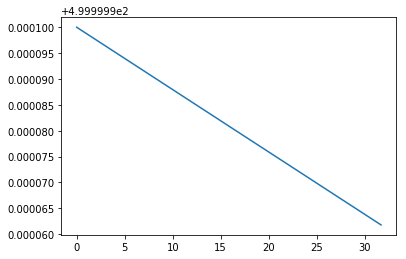

In [19]:
t = np.arange(0,nstep*dt,dt)/3600/24/365.2422 # 単位はyear
plt.plot(t,np.array(r_rev)-R_earth)